In [3]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import warnings
import os
warnings.filterwarnings('ignore')

In [4]:
# Use tf.keras directly for better compatibility
keras = tf.keras
layers = tf.keras.layers

# DATA PREPARATION FOR NEURAL NETWORK
print("\n" + "-" * 40)
print("DATA PREPARATION")
print("-" * 40)

# Load data
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')


----------------------------------------
DATA PREPARATION
----------------------------------------


In [5]:

# Data cleaning
print(f"Original data shape: {df.shape}")

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop ID column
df = df.drop('customerID', axis=1)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print(f"Churn distribution:\n{df['Churn'].value_counts()}")
print(f"Churn rate: {(df['Churn'].sum() / len(df) * 100):.2f}%")

# ----------------------------
# ONE-HOT ENCODE CATEGORICALS
# ----------------------------
df_encoded = pd.get_dummies(df, drop_first=True)

Original data shape: (7043, 21)
Churn distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 26.54%


In [6]:

# Split features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f"Features after encoding: {X.shape[1]}")

Features after encoding: 30


In [7]:

# ----------------------------
# SCALE NUMERICAL FEATURES
# ----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("\nPrepared data shapes:")
print(f"X_train: {X_train_nn.shape}")
print(f"X_test: {X_test_nn.shape}")
print(f"y_train: {y_train_nn.shape}")
print(f"y_test: {y_test_nn.shape}")
print(f"\nTraining set class distribution:")
print(f"Class 0 (No Churn): {(y_train_nn == 0).sum()} ({(y_train_nn == 0).sum()/len(y_train_nn)*100:.2f}%)")
print(f"Class 1 (Churn): {(y_train_nn == 1).sum()} ({(y_train_nn == 1).sum()/len(y_train_nn)*100:.2f}%)")


Prepared data shapes:
X_train: (5634, 30)
X_test: (1409, 30)
y_train: (5634,)
y_test: (1409,)

Training set class distribution:
Class 0 (No Churn): 4139 (73.46%)
Class 1 (Churn): 1495 (26.54%)


In [8]:

# SIMPLE NEURAL NETWORK ARCHITECTURE
print("\n" + "-" * 40)
print("NEURAL NETWORK ARCHITECTURE")
print("-" * 40)

def create_baseline_nn(input_dim):
    """Create a simple baseline neural network"""
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=(input_dim,)),

        # First hidden layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        # Second hidden layer
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        # Output layer (binary classification)
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create the model
input_dim = X_train_nn.shape[1]
model_nn = create_baseline_nn(input_dim)

# Compile the model
model_nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Display model summary
print("\nModel Summary:")
model_nn.summary()


----------------------------------------
NEURAL NETWORK ARCHITECTURE
----------------------------------------

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 192 (768.00 B)

In [9]:

# TRAINING THE NEURAL NETWORK
print("\n" + "-" * 40)
print("TRAINING NEURAL NETWORK")
print("-" * 40)

# Define callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Train the model
history = model_nn.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print(f"\nTraining completed in {len(history.history['loss'])} epochs")


----------------------------------------
TRAINING NEURAL NETWORK
----------------------------------------
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.6437 - auc: 0.6847 - loss: 0.6822 - precision: 0.3929 - recall: 0.6208 - val_accuracy: 0.7693 - val_auc: 0.7891 - val_loss: 0.4845 - val_precision: 0.5738 - val_recall: 0.4610 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7417 - auc: 0.7755 - loss: 0.5119 - precision: 0.5136 - recall: 0.5675 - val_accuracy: 0.7746 - val_auc: 0.8085 - val_loss: 0.4566 - val_precision: 0.5714 - val_recall: 0.5559 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7712 - auc: 0.8037 - loss: 0.4710 - precision: 0.5752 - recall: 0.5383 - val_accuracy: 0.7844 - val_auc: 0.8150 - val_loss: 0.4495 - val_precision: 0.5903 - val_recall: 0.5763 - learning_rate: 0.0010
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7803 - auc: 0.8087 - lo

In [10]:

# EVALUATE NEURAL NETWORK
print("\n" + "-" * 40)
print("NEURAL NETWORK EVALUATION")
print("-" * 40)

# Make predictions
y_pred_nn_prob = model_nn.predict(X_test_nn)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int).flatten()

# Calculate metrics
nn_accuracy = accuracy_score(y_test_nn, y_pred_nn)
nn_precision = precision_score(y_test_nn, y_pred_nn, pos_label=1, zero_division=0)
nn_recall = recall_score(y_test_nn, y_pred_nn, pos_label=1, zero_division=0)
nn_f1 = f1_score(y_test_nn, y_pred_nn, pos_label=1, zero_division=0)
nn_auc = roc_auc_score(y_test_nn, y_pred_nn_prob)

print(f"Neural Network Metrics:")
print(f"  Accuracy:  {nn_accuracy:.4f}")
print(f"  Precision: {nn_precision:.4f}")
print(f"  Recall:    {nn_recall:.4f}")
print(f"  F1-Score:  {nn_f1:.4f}")
print(f"  AUC:       {nn_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_nn, y_pred_nn, target_names=['No Churn', 'Churn'], zero_division=0))

print("Confusion Matrix:")
cm_nn = confusion_matrix(y_test_nn, y_pred_nn)
print(cm_nn)


----------------------------------------
NEURAL NETWORK EVALUATION
----------------------------------------
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Neural Network Metrics:
  Accuracy:  0.7942
  Precision: 0.6355
  Recall:    0.5267
  F1-Score:  0.5760
  AUC:       0.8386

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.86      1035
       Churn       0.64      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

Confusion Matrix:
[[922 113]
 [177 197]]



----------------------------------------
TRAINING HISTORY VISUALIZATION
----------------------------------------


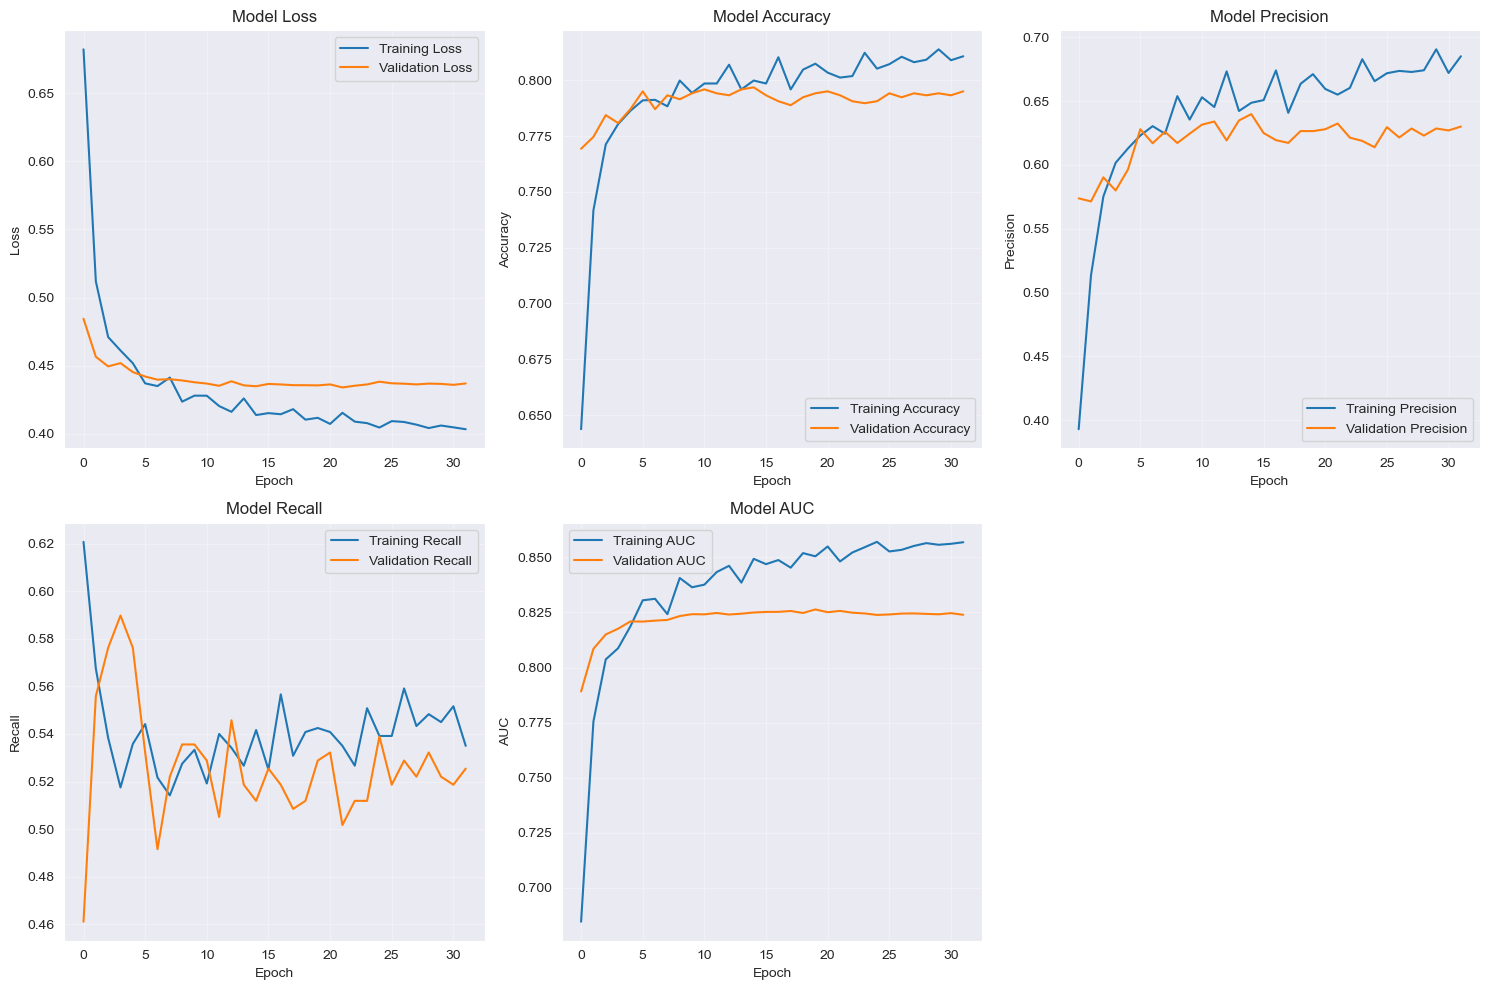

✅ Training history saved to: ../reports/neural_network_training_history.png


In [11]:

# VISUALIZE TRAINING HISTORY
print("\n" + "-" * 40)
print("TRAINING HISTORY VISUALIZATION")
print("-" * 40)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot precision
if 'precision' in history.history:
    axes[0, 2].plot(history.history['precision'], label='Training Precision')
    axes[0, 2].plot(history.history['val_precision'], label='Validation Precision')
    axes[0, 2].set_title('Model Precision')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

# Plot recall
if 'recall' in history.history:
    axes[1, 0].plot(history.history['recall'], label='Training Recall')
    axes[1, 0].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 0].set_title('Model Recall')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Plot AUC
if 'auc' in history.history:
    axes[1, 1].plot(history.history['auc'], label='Training AUC')
    axes[1, 1].plot(history.history['val_auc'], label='Validation AUC')
    axes[1, 1].set_title('Model AUC')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

# Remove empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('../reports/neural_network_training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Training history saved to: ../reports/neural_network_training_history.png")

In [12]:

# NEURAL NETWORK WITH CLASS WEIGHTS (Handling Imbalance)
print("\n" + "=" * 80)
print("NEURAL NETWORK WITH CLASS WEIGHTS")
print("=" * 80)

# Calculate class weights to handle imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_nn),
    y=y_train_nn
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"Class weights: {class_weight_dict}")
print(f"  Class 0 (No Churn) weight: {class_weight_dict[0]:.2f}")
print(f"  Class 1 (Churn) weight: {class_weight_dict[1]:.2f}")

# Create and train model with class weights
model_nn_weighted = create_baseline_nn(input_dim)
model_nn_weighted.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

history_weighted = model_nn_weighted.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=0
)

print(f"Training completed in {len(history_weighted.history['loss'])} epochs")


NEURAL NETWORK WITH CLASS WEIGHTS
Class weights: {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}
  Class 0 (No Churn) weight: 0.68
  Class 1 (Churn) weight: 1.88
Training completed in 10 epochs


In [13]:

# Evaluate weighted model
y_pred_nn_weighted_prob = model_nn_weighted.predict(X_test_nn)
y_pred_nn_weighted = (y_pred_nn_weighted_prob > 0.5).astype(int).flatten()

print(f"\nWeighted Neural Network Results:")
print(f"  Accuracy:  {accuracy_score(y_test_nn, y_pred_nn_weighted):.4f}")
print(f"  Precision: {precision_score(y_test_nn, y_pred_nn_weighted, pos_label=1, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_test_nn, y_pred_nn_weighted, pos_label=1, zero_division=0):.4f}")
print(f"  F1-Score:  {f1_score(y_test_nn, y_pred_nn_weighted, pos_label=1, zero_division=0):.4f}")
print(f"  AUC:       {roc_auc_score(y_test_nn, y_pred_nn_weighted_prob):.4f}")

print("\nClassification Report (Weighted Model):")
print(classification_report(y_test_nn, y_pred_nn_weighted, target_names=['No Churn', 'Churn'], zero_division=0))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Weighted Neural Network Results:
  Accuracy:  0.7168
  Precision: 0.4803
  Recall:    0.8155
  F1-Score:  0.6046
  AUC:       0.8211

Classification Report (Weighted Model):
              precision    recall  f1-score   support

    No Churn       0.91      0.68      0.78      1035
       Churn       0.48      0.82      0.60       374

    accuracy                           0.72      1409
   macro avg       0.70      0.75      0.69      1409
weighted avg       0.80      0.72      0.73      1409




COMPARISON: BASELINE vs WEIGHTED NEURAL NETWORK

Model Comparison:
                    Model  Accuracy  Precision   Recall  F1-Score      AUC
Neural Network (Baseline)   0.79418   0.635484 0.526738  0.576023 0.838647
Neural Network (Weighted)   0.71682   0.480315 0.815508  0.604559 0.821075


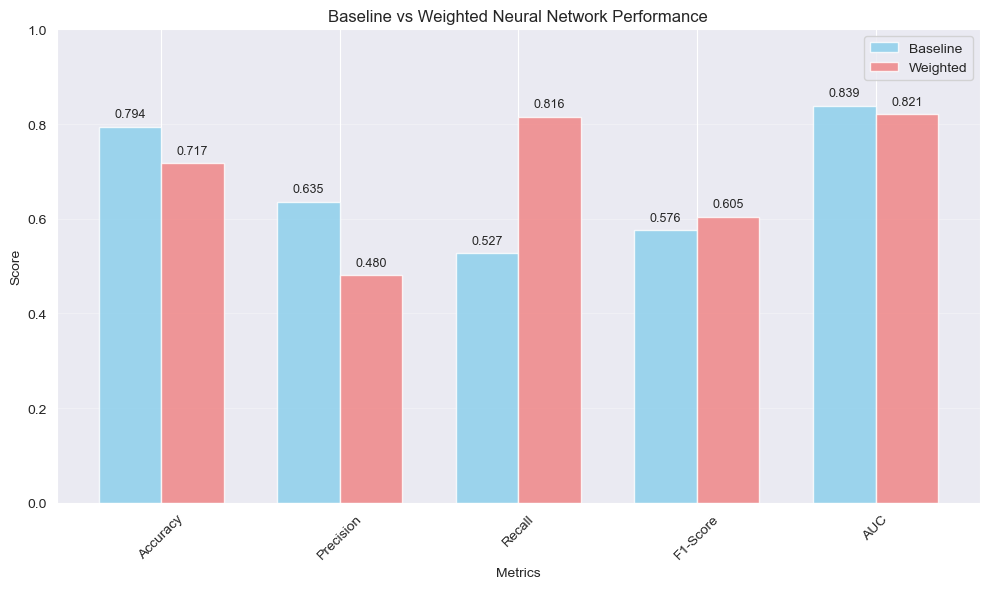

✅ Comparison plot saved to: ../reports/nn_baseline_vs_weighted.png


In [14]:

# VISUALIZE COMPARISON
print("\n" + "=" * 80)
print("COMPARISON: BASELINE vs WEIGHTED NEURAL NETWORK")
print("=" * 80)

# Create comparison table
comparison_data = {
    'Model': ['Neural Network (Baseline)', 'Neural Network (Weighted)'],
    'Accuracy': [nn_accuracy, accuracy_score(y_test_nn, y_pred_nn_weighted)],
    'Precision': [nn_precision, precision_score(y_test_nn, y_pred_nn_weighted, pos_label=1, zero_division=0)],
    'Recall': [nn_recall, recall_score(y_test_nn, y_pred_nn_weighted, pos_label=1, zero_division=0)],
    'F1-Score': [nn_f1, f1_score(y_test_nn, y_pred_nn_weighted, pos_label=1, zero_division=0)],
    'AUC': [nn_auc, roc_auc_score(y_test_nn, y_pred_nn_weighted_prob)]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Visual comparison
fig, ax = plt.subplots(figsize=(10, 6))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics_to_plot))
width = 0.35

# Get metric values
baseline_metrics = [comparison_df.loc[0, m] for m in metrics_to_plot]
weighted_metrics = [comparison_df.loc[1, m] for m in metrics_to_plot]

ax.bar(x - width/2, baseline_metrics, width, label='Baseline', color='skyblue', alpha=0.8)
ax.bar(x + width/2, weighted_metrics, width, label='Weighted', color='lightcoral', alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Baseline vs Weighted Neural Network Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, rotation=45)
ax.set_ylim([0, 1])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (base_val, weight_val) in enumerate(zip(baseline_metrics, weighted_metrics)):
    ax.text(i - width/2, base_val + 0.02, f'{base_val:.3f}', ha='center', fontsize=9)
    ax.text(i + width/2, weight_val + 0.02, f'{weight_val:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../reports/nn_baseline_vs_weighted.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Comparison plot saved to: ../reports/nn_baseline_vs_weighted.png")


----------------------------------------
ROC CURVE COMPARISON
----------------------------------------


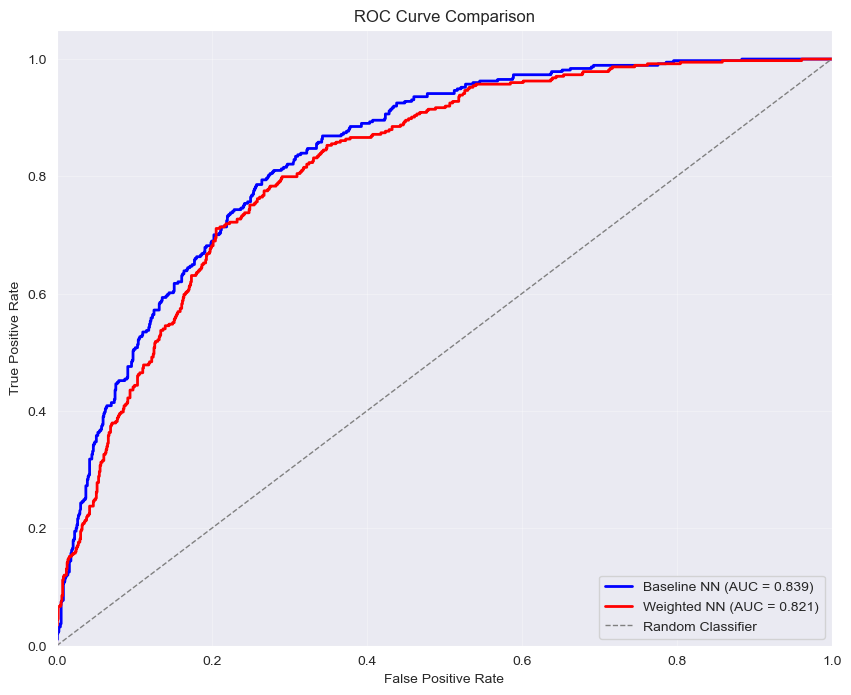

✅ ROC curve saved to: ../reports/roc_curve_comparison.png


In [15]:

# ROC CURVE COMPARISON
print("\n" + "-" * 40)
print("ROC CURVE COMPARISON")
print("-" * 40)

# Calculate ROC curves
fpr_baseline, tpr_baseline, _ = roc_curve(y_test_nn, y_pred_nn_prob)
fpr_weighted, tpr_weighted, _ = roc_curve(y_test_nn, y_pred_nn_weighted_prob)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)
roc_auc_weighted = auc(fpr_weighted, tpr_weighted)

plt.figure(figsize=(10, 8))
plt.plot(fpr_baseline, tpr_baseline, color='blue', lw=2,
         label=f'Baseline NN (AUC = {roc_auc_baseline:.3f})')
plt.plot(fpr_weighted, tpr_weighted, color='red', lw=2,
         label=f'Weighted NN (AUC = {roc_auc_weighted:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('../reports/roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ ROC curve saved to: ../reports/roc_curve_comparison.png")

In [16]:

# SAVE MODELS
print("\n" + "=" * 80)
print("SAVING MODELS")
print("=" * 80)

import joblib

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('reports', exist_ok=True)

# # Save neural network models
# model_nn.save('../models/neural_network_baseline.h5')
# print("✅ Baseline Neural Network model saved to: models/neural_network_baseline.h5")
#
# model_nn_weighted.save('../models/neural_network_weighted.h5')
# print("✅ Weighted Neural Network model saved to: models/neural_network_weighted.h5")
#
# # Save scaler
# joblib.dump(scaler, '../models/scaler.pkl')
# print("✅ Scaler saved to: models/scaler.pkl")

# Save predictions and metrics
results_df = pd.DataFrame({
    'y_true': y_test_nn.values,
    'y_pred_baseline': y_pred_nn,
    'y_prob_baseline': y_pred_nn_prob.flatten(),
    'y_pred_weighted': y_pred_nn_weighted,
    'y_prob_weighted': y_pred_nn_weighted_prob.flatten()
})
results_df.to_csv('../reports/nn_predictions.csv', index=False)
print("✅ Predictions saved to: ../reports/nn_predictions.csv")

# Save comparison results
comparison_df.to_csv('../reports/nn_model_comparison.csv', index=False)
print("✅ Model comparison saved to: ../reports/nn_model_comparison.csv")


SAVING MODELS
✅ Predictions saved to: ../reports/nn_predictions.csv
✅ Model comparison saved to: ../reports/nn_model_comparison.csv


In [17]:

# SUMMARY REPORT
print("\n" + "=" * 80)
print("SUMMARY REPORT")
print("=" * 80)

print("\nBest Performing Neural Network Model:")
best_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
print(f"  Model: {best_model_name}")
print(f"  F1-Score: {comparison_df.loc[best_idx, 'F1-Score']:.4f}")
print(f"  Accuracy: {comparison_df.loc[best_idx, 'Accuracy']:.4f}")
print(f"  Recall: {comparison_df.loc[best_idx, 'Recall']:.4f}")
print(f"  Precision: {comparison_df.loc[best_idx, 'Precision']:.4f}")
print(f"  AUC: {comparison_df.loc[best_idx, 'AUC']:.4f}")

print("\n" + "=" * 80)
print("NEURAL NETWORK IMPLEMENTATION COMPLETE!")
print("=" * 80)


SUMMARY REPORT

Best Performing Neural Network Model:
  Model: Neural Network (Weighted)
  F1-Score: 0.6046
  Accuracy: 0.7168
  Recall: 0.8155
  Precision: 0.4803
  AUC: 0.8211

NEURAL NETWORK IMPLEMENTATION COMPLETE!


In [19]:
# ============================================================================
# SIMPLE HYPERPARAMETER GRID SEARCH
# ============================================================================
print("\n" + "=" * 80)
print("SIMPLE GRID SEARCH FOR NEURAL NETWORK")
print("=" * 80)

# Split training data into training and validation sets for hyperparameter tuning
X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
    X_train_nn, y_train_nn,
    test_size=0.2,
    random_state=42,
    stratify=y_train_nn
)

print(f"Training set for tuning: {X_train_tune.shape}")
print(f"Validation set for tuning: {X_val_tune.shape}")

# Define hyperparameter grid
param_grid = {
    'hidden_units': [(64, 32), (128, 64), (256, 128)],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [16, 32, 64]
}

best_score = 0
best_params = {}
best_model_grid = None

results = []

# Calculate total combinations
total_combos = (
    len(param_grid['hidden_units']) *
    len(param_grid['dropout_rate']) *
    len(param_grid['learning_rate']) *
    len(param_grid['batch_size'])
)
current_combo = 0

for hidden_units in param_grid['hidden_units']:
    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:

                current_combo += 1
                print(f"\n[{current_combo}/{total_combos}] Trying: "
                      f"hidden_units={hidden_units}, dropout={dropout_rate}, "
                      f"lr={learning_rate}, batch_size={batch_size}")

                # Build model
                model = tf.keras.Sequential([
                    tf.keras.layers.Input(shape=(input_dim,)),
                    tf.keras.layers.Dense(hidden_units[0], activation='relu'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout_rate),
                    tf.keras.layers.Dense(hidden_units[1], activation='relu'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout_rate),
                    tf.keras.layers.Dense(1, activation='sigmoid')
                ])

                model.compile(
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'auc']
                )

                # Train with early stopping
                history = model.fit(
                    X_train_tune, y_train_tune,  # Use training subset for tuning
                    validation_data=(X_val_tune, y_val_tune),  # Use validation subset
                    epochs=50,
                    batch_size=batch_size,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
                    ],
                    verbose=0
                )

                # Evaluate on validation set
                y_pred_prob = model.predict(X_val_tune, verbose=0)
                auc_score = roc_auc_score(y_val_tune, y_pred_prob)

                # Also calculate F1 score for churn prediction
                y_pred = (y_pred_prob > 0.5).astype(int).flatten()
                f1 = f1_score(y_val_tune, y_pred, pos_label=1, zero_division=0)

                results.append({
                    'hidden_units': str(hidden_units),
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'batch_size': batch_size,
                    'val_auc': auc_score,
                    'val_f1': f1,
                    'epochs': len(history.history['loss'])
                })

                print(f"  AUC: {auc_score:.4f}, F1: {f1:.4f}, Epochs: {len(history.history['loss'])}")

                # Use F1 score as primary metric (better for imbalanced churn data)
                if f1 > best_score:
                    best_score = f1
                    best_params = {
                        'hidden_units': hidden_units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'val_f1': f1,
                        'val_auc': auc_score
                    }
                    best_model_grid = model

print("\n" + "=" * 80)
print("BEST PARAMETERS FROM GRID SEARCH:")
print("=" * 80)
for key, value in best_params.items():
    print(f"{key}: {value}")
print(f"Best Validation F1-Score: {best_score:.4f}")

# Save results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('val_f1', ascending=False)
results_df.to_csv('../reports/hyperparameter_tuning_results.csv', index=False)
print(f"\n✅ Hyperparameter tuning results saved to: ../reports/hyperparameter_tuning_results.csv")

# Display top 10 combinations
print("\n" + "=" * 80)
print("TOP 10 HYPERPARAMETER COMBINATIONS:")
print("=" * 80)
print(results_df.head(10).to_string(index=False))


SIMPLE GRID SEARCH FOR NEURAL NETWORK
Training set for tuning: (4507, 30)
Validation set for tuning: (1127, 30)

[1/81] Trying: hidden_units=(64, 32), dropout=0.2, lr=0.001, batch_size=16
  AUC: 0.8458, F1: 0.6056, Epochs: 12

[2/81] Trying: hidden_units=(64, 32), dropout=0.2, lr=0.001, batch_size=32
  AUC: 0.8461, F1: 0.6093, Epochs: 20

[3/81] Trying: hidden_units=(64, 32), dropout=0.2, lr=0.001, batch_size=64
  AUC: 0.8455, F1: 0.6004, Epochs: 16

[4/81] Trying: hidden_units=(64, 32), dropout=0.2, lr=0.0005, batch_size=16
  AUC: 0.8464, F1: 0.6190, Epochs: 12

[5/81] Trying: hidden_units=(64, 32), dropout=0.2, lr=0.0005, batch_size=32
  AUC: 0.8452, F1: 0.6067, Epochs: 22

[6/81] Trying: hidden_units=(64, 32), dropout=0.2, lr=0.0005, batch_size=64
  AUC: 0.8450, F1: 0.6142, Epochs: 35

[7/81] Trying: hidden_units=(64, 32), dropout=0.2, lr=0.0001, batch_size=16
  AUC: 0.8390, F1: 0.6052, Epochs: 45

[8/81] Trying: hidden_units=(64, 32), dropout=0.2, lr=0.0001, batch_size=32
  AUC: 0


EVALUATING TUNED MODEL AND COMPARING WITH PREVIOUS MODELS

📊 RETRIEVING PREVIOUS MODEL RESULTS...
----------------------------------------
Baseline Model Results:
  Accuracy:  0.7942
  Precision: 0.6355
  Recall:    0.5267
  F1-Score:  0.5760
  AUC:       0.8386

Weighted Model Results:
  Accuracy:  0.7168
  Precision: 0.4803
  Recall:    0.8155
  F1-Score:  0.6046
  AUC:       0.8211

TRAINING BEST TUNED MODEL ON FULL TRAINING DATA
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5531 - auc: 0.5697 - loss: 0.8899 - precision: 0.3051 - recall: 0.5308 - val_accuracy: 0.6477 - val_auc: 0.6994 - val_loss: 0.6438 - val_precision: 0.3959 - val_recall: 0.6576 - learning_rate: 1.0000e-04
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6304 - auc: 0.6779 - loss: 0.7526 - precision: 0.3818 - recall: 0.6275 - val_accuracy: 0.7187 - val_auc: 0.7604 - val_loss: 0.5759 - val_precision: 0.4729 - val_recall: 0.6508 - learning_rate: 1.0000e-04
Epoch 3/100
141/14

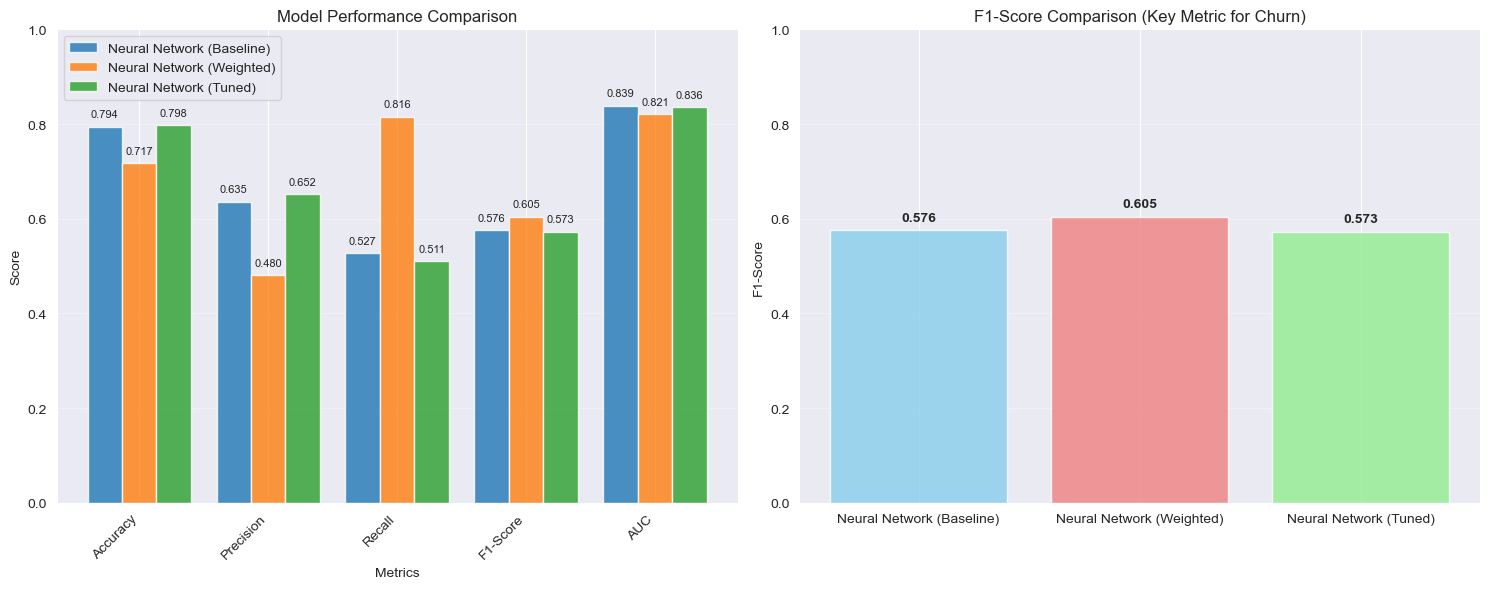

✅ Model comparison plot saved to: ../reports/nn_model_comparison_after_tuning.png

SAVING RESULTS
✅ Tuned model saved to: ../models/neural_network_tuned.h5
✅ Model comparison saved to: ../reports/nn_final_model_comparison.csv
✅ Tuned model predictions saved

HYPERPARAMETER TUNING EVALUATION COMPLETE!


In [20]:
# ============================================================================
# EVALUATE BEST TUNED MODEL AND COMPARE WITH PREVIOUS MODELS
# ============================================================================
print("\n" + "=" * 80)
print("EVALUATING TUNED MODEL AND COMPARING WITH PREVIOUS MODELS")
print("=" * 80)

# 1. FIRST, GET YOUR PREVIOUS MODEL RESULTS
print("\n📊 RETRIEVING PREVIOUS MODEL RESULTS...")
print("-" * 40)

# Your baseline model results (from earlier in your notebook)
# If these variables don't exist, you need to run your baseline model evaluation first
try:
    print(f"Baseline Model Results:")
    print(f"  Accuracy:  {nn_accuracy:.4f}")
    print(f"  Precision: {nn_precision:.4f}")
    print(f"  Recall:    {nn_recall:.4f}")
    print(f"  F1-Score:  {nn_f1:.4f}")
    print(f"  AUC:       {nn_auc:.4f}")

    baseline_results = {
        'Model': 'Neural Network (Baseline)',
        'Accuracy': nn_accuracy,
        'Precision': nn_precision,
        'Recall': nn_recall,
        'F1-Score': nn_f1,
        'AUC': nn_auc
    }
except NameError:
    print("⚠️ Baseline model results not found. Run baseline model evaluation first.")
    # You can run this quick evaluation if needed:
    print("Running quick baseline evaluation...")
    # Add your baseline model evaluation code here

# Your weighted model results (from earlier in your notebook)
try:
    weighted_accuracy = accuracy_score(y_test_nn, y_pred_nn_weighted)
    weighted_precision = precision_score(y_test_nn, y_pred_nn_weighted, pos_label=1, zero_division=0)
    weighted_recall = recall_score(y_test_nn, y_pred_nn_weighted, pos_label=1, zero_division=0)
    weighted_f1 = f1_score(y_test_nn, y_pred_nn_weighted, pos_label=1, zero_division=0)
    weighted_auc = roc_auc_score(y_test_nn, y_pred_nn_weighted_prob)

    print(f"\nWeighted Model Results:")
    print(f"  Accuracy:  {weighted_accuracy:.4f}")
    print(f"  Precision: {weighted_precision:.4f}")
    print(f"  Recall:    {weighted_recall:.4f}")
    print(f"  F1-Score:  {weighted_f1:.4f}")
    print(f"  AUC:       {weighted_auc:.4f}")

    weighted_results = {
        'Model': 'Neural Network (Weighted)',
        'Accuracy': weighted_accuracy,
        'Precision': weighted_precision,
        'Recall': weighted_recall,
        'F1-Score': weighted_f1,
        'AUC': weighted_auc
    }
except NameError:
    print("⚠️ Weighted model results not found.")

# 2. TRAIN BEST TUNED MODEL ON FULL TRAINING DATA
print("\n" + "=" * 80)
print("TRAINING BEST TUNED MODEL ON FULL TRAINING DATA")
print("=" * 80)

# Rebuild best model with best parameters
best_tuned_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(best_params['hidden_units'][0], activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(best_params['dropout_rate']),
    tf.keras.layers.Dense(best_params['hidden_units'][1], activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(best_params['dropout_rate']),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

best_tuned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc', 'precision', 'recall']
)

# Train on full training data
history_tuned = best_tuned_model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=best_params['batch_size'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ],
    verbose=1
)

print(f"\nTraining completed in {len(history_tuned.history['loss'])} epochs")

# 3. EVALUATE TUNED MODEL ON TEST SET
print("\n" + "=" * 80)
print("EVALUATING TUNED MODEL ON TEST SET")
print("=" * 80)

y_pred_tuned_prob = best_tuned_model.predict(X_test_nn)
y_pred_tuned = (y_pred_tuned_prob > 0.5).astype(int).flatten()

# Calculate metrics for tuned model
tuned_accuracy = accuracy_score(y_test_nn, y_pred_tuned)
tuned_precision = precision_score(y_test_nn, y_pred_tuned, pos_label=1, zero_division=0)
tuned_recall = recall_score(y_test_nn, y_pred_tuned, pos_label=1, zero_division=0)
tuned_f1 = f1_score(y_test_nn, y_pred_tuned, pos_label=1, zero_division=0)
tuned_auc = roc_auc_score(y_test_nn, y_pred_tuned_prob)

print(f"Tuned Model Results:")
print(f"  Accuracy:  {tuned_accuracy:.4f}")
print(f"  Precision: {tuned_precision:.4f}")
print(f"  Recall:    {tuned_recall:.4f}")
print(f"  F1-Score:  {tuned_f1:.4f}")
print(f"  AUC:       {tuned_auc:.4f}")

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test_nn, y_pred_tuned, target_names=['No Churn', 'Churn'], zero_division=0))

print("Confusion Matrix (Tuned Model):")
cm_tuned = confusion_matrix(y_test_nn, y_pred_tuned)
print(cm_tuned)

tuned_results = {
    'Model': 'Neural Network (Tuned)',
    'Accuracy': tuned_accuracy,
    'Precision': tuned_precision,
    'Recall': tuned_recall,
    'F1-Score': tuned_f1,
    'AUC': tuned_auc
}

# 4. COMPARE ALL MODELS
print("\n" + "=" * 80)
print("COMPARING ALL MODELS")
print("=" * 80)

# Create comparison dataframe
all_models_data = []

# Add baseline model if available
if 'baseline_results' in locals():
    all_models_data.append(baseline_results)

# Add weighted model if available
if 'weighted_results' in locals():
    all_models_data.append(weighted_results)

# Add tuned model
all_models_data.append(tuned_results)

# Create comparison table
comparison_df = pd.DataFrame(all_models_data)

print("\n📈 MODEL COMPARISON TABLE:")
print("-" * 60)
print(comparison_df.to_string(index=False))

# Find best model for each metric
print("\n🏆 BEST MODEL FOR EACH METRIC:")
print("-" * 40)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"{metric}: {best_model} ({best_value:.4f})")

# Overall best model (based on F1-Score for churn prediction)
best_f1_idx = comparison_df['F1-Score'].idxmax()
best_model_overall = comparison_df.loc[best_f1_idx, 'Model']
print(f"\n✨ OVERALL BEST MODEL (based on F1-Score): {best_model_overall} ✨")
print(f"   F1-Score: {comparison_df.loc[best_f1_idx, 'F1-Score']:.4f}")
print(f"   Precision: {comparison_df.loc[best_f1_idx, 'Precision']:.4f}")
print(f"   Recall: {comparison_df.loc[best_f1_idx, 'Recall']:.4f}")

# 5. CALCULATE IMPROVEMENT FROM BASELINE
if 'baseline_results' in locals():
    print("\n" + "=" * 80)
    print("IMPROVEMENT ANALYSIS")
    print("=" * 80)

    f1_improvement = tuned_f1 - nn_f1
    precision_improvement = tuned_precision - nn_precision

    print(f"Tuned vs Baseline Improvement:")
    print(f"  F1-Score: {f1_improvement:+.4f} ({f1_improvement*100:+.1f}%)")
    print(f"  Precision: {precision_improvement:+.4f} ({precision_improvement*100:+.1f}%)")

    if f1_improvement > 0:
        print(f"\n✅ Hyperparameter tuning IMPROVED F1-Score by {f1_improvement*100:+.1f}%")
    else:
        print(f"\n⚠️ Hyperparameter tuning did NOT improve F1-Score")

# 6. VISUALIZE COMPARISON
print("\n" + "=" * 80)
print("VISUALIZING MODEL COMPARISON")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics_to_plot))
width = 0.8 / len(comparison_df)  # Dynamic width based on number of models

for i, (_, row) in enumerate(comparison_df.iterrows()):
    model_metrics = [row[m] for m in metrics_to_plot]
    axes[0].bar(x + i*width - (len(comparison_df)-1)*width/2,
                model_metrics, width, label=row['Model'], alpha=0.8)

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, metric in enumerate(metrics_to_plot):
    for j, (_, row) in enumerate(comparison_df.iterrows()):
        height = row[metric]
        axes[0].text(i + j*width - (len(comparison_df)-1)*width/2,
                    height + 0.02, f'{height:.3f}',
                    ha='center', fontsize=8)

# F1-Score focused comparison
models = comparison_df['Model'].tolist()
f1_scores = comparison_df['F1-Score'].tolist()

colors = ['skyblue', 'lightcoral', 'lightgreen'][:len(models)]
axes[1].bar(models, f1_scores, color=colors, alpha=0.8)
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score Comparison (Key Metric for Churn)')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (model, score) in enumerate(zip(models, f1_scores)):
    axes[1].text(i, score + 0.02, f'{score:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/nn_model_comparison_after_tuning.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Model comparison plot saved to: ../reports/nn_model_comparison_after_tuning.png")

# Save predictions
predictions_df = pd.DataFrame({
    'y_true': y_test_nn.values,
    'y_pred_tuned': y_pred_tuned,
    'y_prob_tuned': y_pred_tuned_prob.flatten()
})
predictions_df.to_csv('../reports/nn_tuned_predictions.csv', index=False)
print("✅ Tuned model predictions saved")

print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING EVALUATION COMPLETE!")
print("=" * 80)